In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score

#paper_style()

from helper_fn import *

sys.path.append("..")

# from modules.utils import paper_style

# loading GT stuff

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = False

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

#crossing_points_gt, idx_gt = find_crossing_points(taus, gt_tracks)

track_lengths = [track.shape[0] for track in gt_tracks]

modalities = ["bf", "h2b"]

In [83]:
data = {}
errors_g = {}
errors_r = {}
for mod in modalities:
    data[mod] = {}
    errors_g[mod] = {}
    errors_r[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

In [84]:
# subset of heads to plot
good_heads = ["mlp", "cnn", "mamba", "xtransformer"]
data['bf']['GT'] = gt_tracks
data['h2b']['GT'] = gt_tracks

In [95]:
len(gt_tracks)

358

# tables 
# normal

In [110]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

columns = ['L_1', 'L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'R^2', 'DTW', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'Mamba', 'Transformer'])}
rows = []

for mod in ['bf', 'h2b']:
    for head in good_heads:
        print(mod, head)
        l1 = np.mean([mean_absolute_error(data[mod][head][idx], data[mod]['GT'][idx]) for idx in range(len(gt_tracks))])
        l1_red = np.mean([mean_absolute_error(data[mod][head][idx][:, 1], data[mod]['GT'][idx][:, 1]) for idx in range(len(gt_tracks))])
        l1_green = np.mean([mean_absolute_error(data[mod][head][idx][:, 0], data[mod]['GT'][idx][:, 0]) for idx in range(len(gt_tracks))])
        r2 = np.mean([max(r2_score(gt_tracks[idx],data[mod][head][idx]), 0) for idx in range(len(gt_tracks))])
        dtw_val = np.mean([fastdtw(data[mod][head][idx], data[mod]['GT'][idx], dist=euclidean, )[0] for idx in range(len(gt_tracks))])
        rows.append((round(l1, 3), round(l1_red, 3), round(l1_green, 3), round(r2, 3), round(dtw_val, 3) ))

#for idx in range(len(gt_tracks)): 
#    print(r2_score(data[mod]["cnn"][idx][:, :], gt_tracks[idx]) )
data_ = pd.concat([pd.DataFrame(rows[:len(rows)//2]), pd.DataFrame(rows[len(rows)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
data_.index =list( models.values() )

bf mlp
bf cnn
bf mamba
bf xtransformer
h2b mlp
h2b cnn
h2b mamba
h2b xtransformer


In [ ]:
latex_df = data_.copy()
import itertools
for col in itertools.product(list(super_columns.values()), ['L_1', 'L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'DTW']):
    min_value = data_[col].min()
    latex_df[col] = data_[col].apply(
        lambda x: f"\\textbf{{{x:.3f}}}" if x == min_value else f"{x:.3f}"
    )

for col in itertools.product(list(super_columns.values()), ['R^2']):
    max_value = data_[col].max()
    latex_df[col] = data_[col].apply(
        lambda x: f"\\textbf{{{x:.3f}}}" if x == max_value else f"{x:.3f}"
    )

latex_df.to_latex(index=True, escape=False)
# Save the LaTeX table to a file
with open("table1.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))


## with the std +- 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statistics import mean, stdev

columns = ['L_1', 'L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'R^2', 'DTW', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'Mamba', 'Transformer'])}
rows = []

for mod in ['bf', 'h2b']:
    for head in good_heads:
        print(mod, head)
        l1_values = [mean_absolute_error(data[mod][head][idx], data[mod]['GT'][idx]) for idx in range(len(gt_tracks))]
        l1_red_values = [mean_absolute_error(data[mod][head][idx][:, 1], data[mod]['GT'][idx][:, 1]) for idx in range(len(gt_tracks))]
        l1_green_values = [mean_absolute_error(data[mod][head][idx][:, 0], data[mod]['GT'][idx][:, 0]) for idx in range(len(gt_tracks))]
        r2_values = [max(r2_score(gt_tracks[idx], data[mod][head][idx]), 0) for idx in range(len(gt_tracks))]
        dtw_values = [fastdtw(data[mod][head][idx], data[mod]['GT'][idx], dist=euclidean)[0] for idx in range(len(gt_tracks))]

        l1_mean, l1_std = mean(l1_values), stdev(l1_values)
        l1_red_mean, l1_red_std = mean(l1_red_values), stdev(l1_red_values)
        l1_green_mean, l1_green_std = mean(l1_green_values), stdev(l1_green_values)
        r2_mean, r2_std = mean(r2_values), stdev(r2_values)
        dtw_mean, dtw_std = mean(dtw_values), stdev(dtw_values)

        rows.append((
            f"{l1_mean:.3f} ± {l1_std:.3f}",
            f"{l1_red_mean:.3f} ± {l1_red_std:.3f}",
            f"{l1_green_mean:.3f} ± {l1_green_std:.3f}",
            f"{r2_mean:.3f} ± {r2_std:.3f}",
            f"{dtw_mean:.3f} ± {dtw_std:.3f}"
        ))
#for idx in range(len(gt_tracks)): 
#    print(r2_score(data[mod]["cnn"][idx][:, :], gt_tracks[idx]) )
data_ = pd.concat([pd.DataFrame(rows[:len(rows)//2]), pd.DataFrame(rows[len(rows)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
data_.index =list( models.values() )

bf mlp
bf cnn
bf mamba
bf xtransformer
h2b mlp
h2b cnn
h2b mamba
h2b xtransformer


In [118]:
new_col = pd.MultiIndex.from_product([list(super_columns.values()), columns[1:]])
new_col

MultiIndex([('Brightfield', 'L_{1, FUCCI_1}'),
            ('Brightfield', 'L_{1, FUCCI_2}'),
            ('Brightfield',            'R^2'),
            ('Brightfield',            'DTW'),
            ('Histone H2B', 'L_{1, FUCCI_1}'),
            ('Histone H2B', 'L_{1, FUCCI_2}'),
            ('Histone H2B',            'R^2'),
            ('Histone H2B',            'DTW')],
           )

In [119]:
data_[new_col]

Brightfield                                                 \
             L_{1, FUCCI_1} L_{1, FUCCI_2}            R^2              DTW   
Single Frame  0.193 ± 0.066  0.146 ± 0.045  0.471 ± 0.225  43.648 ± 14.808   
Causal CNN    0.157 ± 0.078  0.122 ± 0.049  0.622 ± 0.239  27.772 ± 14.050   
Mamba         0.112 ± 0.072  0.091 ± 0.049  0.750 ± 0.236  13.351 ± 11.151   
Transformer   0.066 ± 0.038  0.062 ± 0.037  0.892 ± 0.111   11.956 ± 7.352   

                Histone H2B                                                 
             L_{1, FUCCI_1} L_{1, FUCCI_2}            R^2              DTW  
Single Frame  0.183 ± 0.104  0.130 ± 0.064  0.543 ± 0.309  27.908 ± 17.206  
Causal CNN    0.154 ± 0.105  0.118 ± 0.061  0.627 ± 0.306  23.401 ± 16.591  
Mamba         0.074 ± 0.057  0.075 ± 0.040  0.861 ± 0.154  13.191 ± 11.015  
Transformer   0.056 ± 0.039  0.054 ± 0.033  0.912 ± 0.116   11.069 ± 7.382

In [122]:
# Convert all columns to numeric, coercing errors to NaN
latex_df = data_[new_col].copy()
import re

# Function to extract mean value from "mean ± std" format
def extract_mean(value):
    # Use regex to extract the mean part of the string before '±'
    match = re.match(r"([\d.]+)", value)
    return float(match.group(1)) if match else float('inf')  # Use 'inf' for invalid cases

# Highlight minimum values for specific metrics based on mean
for col in itertools.product(list(super_columns.values()),  ['L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'DTW']):
    # Extract mean values and find the minimum
    min_value = min(data_[col].apply(extract_mean))
    latex_df[col] = data_[col].apply(
        lambda x: f"\\textbf{{{x}}}" if extract_mean(x) == min_value else x
    )

# Highlight maximum values for R^2 based on mean
for col in itertools.product(list(super_columns.values()), ['R^2']):
    # Extract mean values and find the maximum
    max_value = max(data_[col].apply(extract_mean))
    latex_df[col] = data_[col].apply(
        lambda x: f"\\textbf{{{x}}}" if extract_mean(x) == max_value else x
    )

latex_df.to_latex(index=True, escape=False)
# Save the LaTeX table to a file
with open("table1.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))


In [35]:
pd.MultiIndex.from_product([super_columns.values(), columns])

MultiIndex([('Brightfield',            'R^2'),
            ('Brightfield',            'DTW'),
            ('Brightfield',            'L_1'),
            ('Brightfield', 'L_{1, FUCCI_1}'),
            ('Brightfield', 'L_{1, FUCCI_2}'),
            ('Histone H2B',            'R^2'),
            ('Histone H2B',            'DTW'),
            ('Histone H2B',            'L_1'),
            ('Histone H2B', 'L_{1, FUCCI_1}'),
            ('Histone H2B', 'L_{1, FUCCI_2}')],
           )

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
import itertools

table = pd.DataFrame()
data 
for mod in ['bf', 'h2b']:
    for head in good_heads:
        l1, l1_red, l1_green, r2, dtw = ([] for _ in range(5))
        for idx in range(len(gt_tracks)):
            l1.append(  mean_absolute_error(data[mod][head][idx], data[mod]['GT'][idx]) )
            l1_red.append(  mean_absolute_error(data[mod][head][idx][:, 1 ], data[mod]['GT'][idx][:, 1]) )
            l1_green.append(  mean_absolute_error(data[mod][head][idx][:, 0], data[mod]['GT'][idx][:, 0]) )
            r2.append(  r2_score(data[mod][head][idx], data[mod]['GT'][idx]) )
            dtw.append(  dtw.distance(data[mod][head][idx],  data[mod]['GT'][idx], **kwargs) )

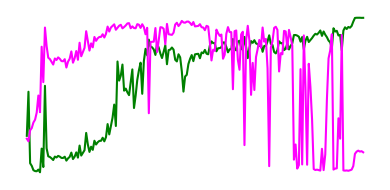

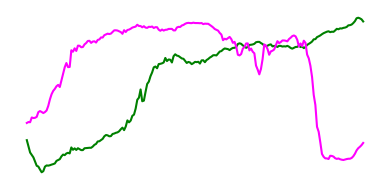

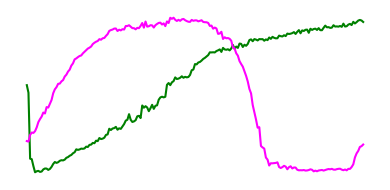

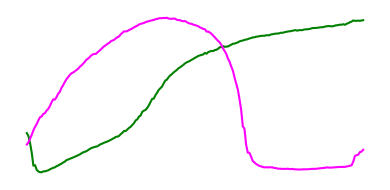

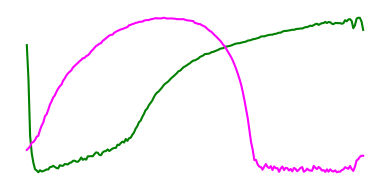

In [20]:
mod = "bf"
idx = 25


for head in good_heads:
    fig, ax1 = plt.subplots(1, 1, figsize=(4, 2), sharey=True)

    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color="green", alpha=1)
    ax1.plot(data[mod][head][idx][:, 1], label=f"{head}", color="magenta", alpha=1)
    #ax1.grid('off')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.axis('off')
    plt.savefig(f'{head}_track.png', bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()

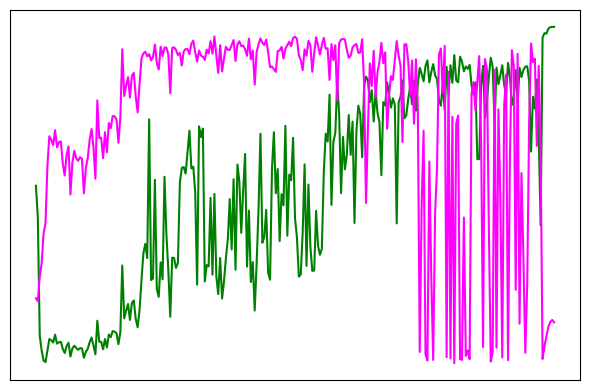

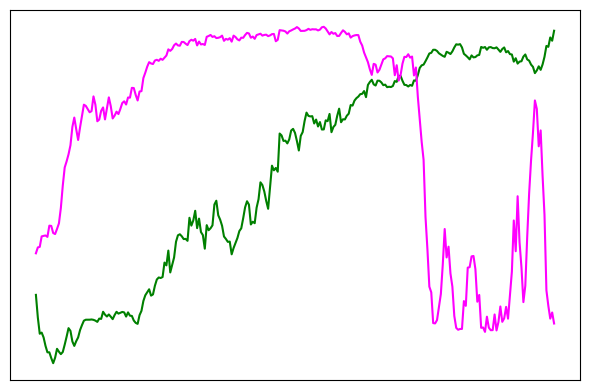

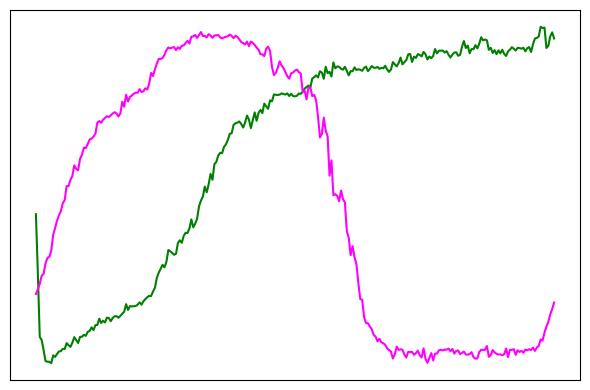

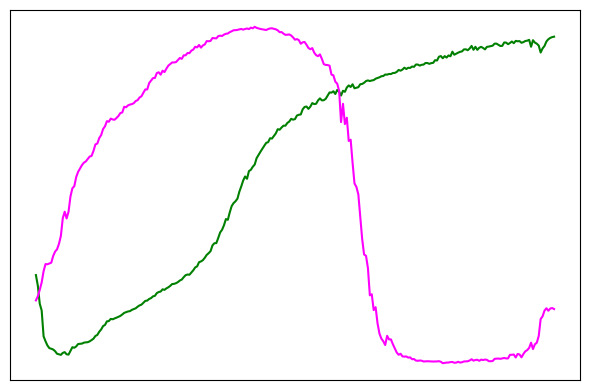

KeyError: 'GT'

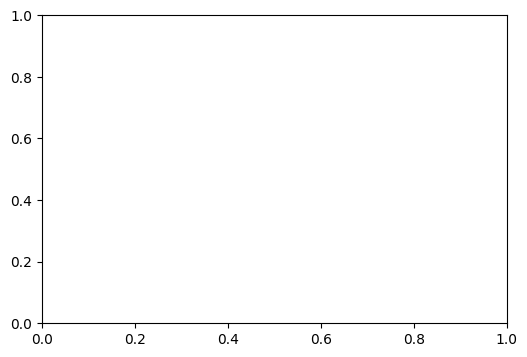

In [6]:
mod = "bf"
idx = 115


for head in good_heads:
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharey=True)

    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color="green", alpha=1)
    ax1.plot(data[mod][head][idx][:, 1], label=f"{head}", color="magenta", alpha=1)
    #ax1.grid('off')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines.top =  True
    ax1.spines.right = True
    plt.tight_layout()
    plt.show()

## checkpoints

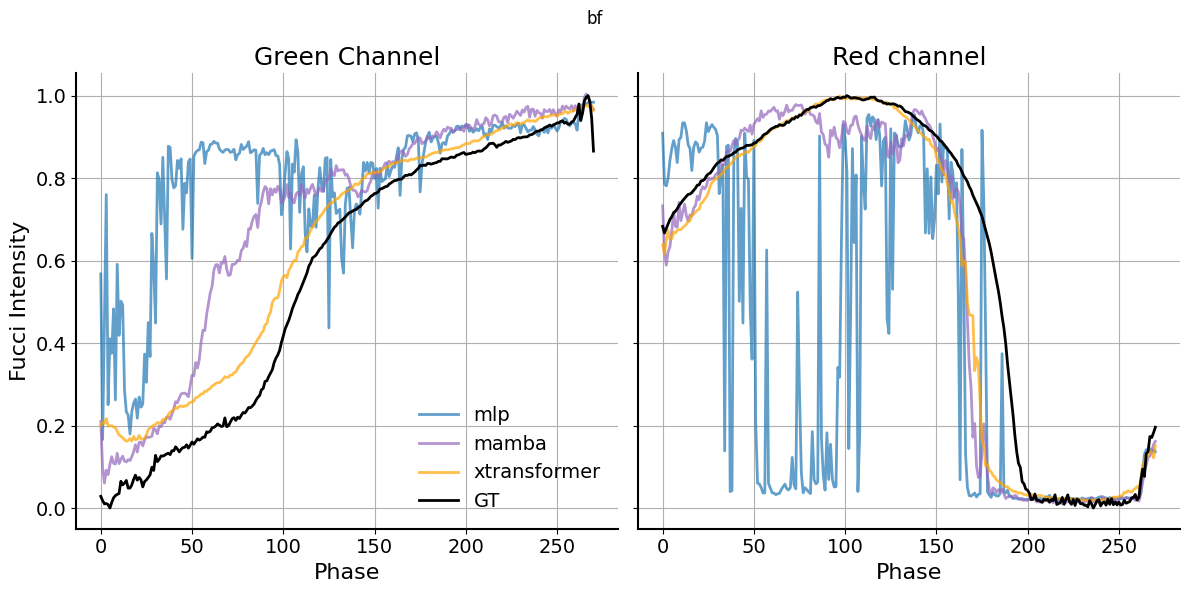

In [12]:
# choose modality here
mod = "bf"
# choose track here
idx = 119
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle(mod)

# Left subplot for errors_g_averaged
ax1.set_title("Green Channel")
ax1.set_xlabel("Phase")
ax1.set_ylabel("Fucci Intensity")


for head in good_heads:
    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color=head_colors[head], alpha=0.7)

ax1.plot(gt_tracks[idx][:, 0], label="GT", color="black")
ax1.legend()
ax1.grid()

# Right subplot for errors_r_averaged
ax2.set_title("Red channel")
ax2.set_xlabel("Phase")

for head in good_heads:
    ax2.plot(data[mod][head][idx][:, 1], label=f"{head}", color=head_colors[head], alpha=0.7)

ax2.plot(gt_tracks[idx][:, 1], label="GT", color="black")

# ax2.legend()
ax2.grid()

# Ensure tight layout and consistent y-axis scaling
plt.tight_layout()

# save the figure
# plt.savefig(f"../plots/av_error/profile_{mod}.pdf")
plt.show()

## avarage error profile

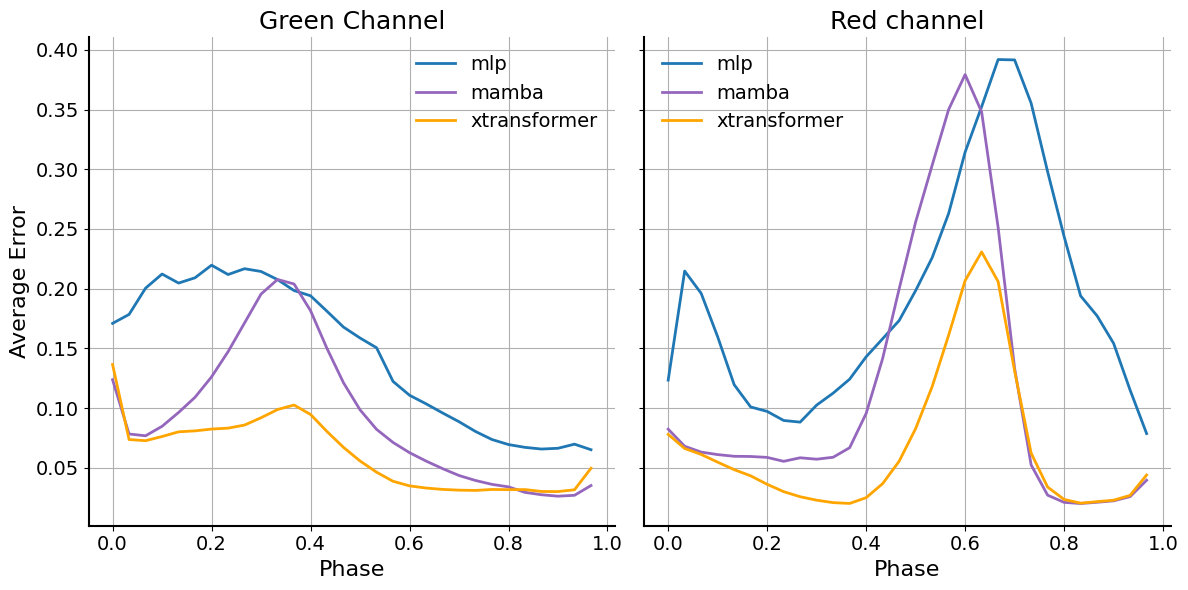

In [14]:
# Create the figure and subplots
mod = "bf"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left subplot for errors_g_averaged
ax1.set_title("Green Channel")
ax1.set_xlabel("Phase")
ax1.set_ylabel("Average Error")
for head in good_heads:
    errors_g_averaged = errors_g[mod][head]
    ax1.plot(bins[:-1], errors_g_averaged, label=f"{head}", color=head_colors[head])

ax1.legend()
ax1.grid()

# Right subplot for errors_r_averaged
ax2.set_title("Red channel")
ax2.set_xlabel("Phase")
for head in good_heads:
    errors_r_averaged = errors_r[mod][head]
    ax2.plot(bins[:-1], errors_r_averaged, label=f"{head}", color=head_colors[head])

ax2.legend()
ax2.grid()

# Ensure tight layout and consistent y-axis scaling
plt.tight_layout()


# save as pdf in ../plots/av_error
#plt.savefig(f"../plots/av_error/av_error.pdf")
plt.show()

# drugs

Here I do the same thing, just switch the drug flag on

In [ ]:
# MAXINE! take the same code above and so the same plots


In [28]:
drug = True

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

data_d = {}
for mod in modalities:
    data_d[mod] = {}
    for head in heads:
        tracks = get_data(data_path_, mod, head)
        data_d[mod][head] = tracks

gt_tracks_d = []
taus_d = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks_d.append(track)
    taus_d.append(tau)